In [20]:
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
# from tqdm import tqdm
from progressbar import ProgressBar
import h5py
import matplotlib.pyplot as plt
from natsort import natsorted
I=0
def _parse_function(example_proto):
    print('1')
    w=1
    features = {"X": tf.FixedLenFeature((w*257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    print("i was here")
    print('2')
    return parsed_features["X"], parsed_features["Y"]

def rbm_layer(n_visible, n_hidden, num_epochs, numcases, lr, lrh, ws, bs, layer_n, len_data, directories):
    Data_path = directories[0]
    tfrecord_folder_parent = directories[1]
    tfrecord_folder = directories[2]
    
    tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
    sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
    trainfilenames_x = []
    for i in sorted_names_x:
        trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path_x,i)))
#     filenames_x = tf.placeholder(tf.string, shape=[None])
#     dataset_x = tf.data.TFRecordDataset(filenames_x)
    dataset_x = tf.data.TFRecordDataset(trainfilenames_x)
    dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
#     dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
    dataset_x = dataset_x.batch(numcases)
#     iterator_x = dataset_x.make_initializable_iterator()
    
    weightcost  = 0.009
    initialmomentum  = 0.5
    finalmomentum    = 0.9

#     weightcost  = 0
#     initialmomentum  = 0
#     finalmomentum    = 0
#     momentum  = 0.5
    W_adder  = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
    bh_adder = tf.zeros((1,n_hidden),dtype=tf.dtypes.float32)
    bv_adder = tf.zeros((1,n_visible),dtype=tf.dtypes.float32)
    
    
#     x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
#     h = tf.placeholder(tf.float32, [None, n_hidden], name="h")
#     h = tf.zeros((numcases, n_hidden),dtype=tf.dtypes.float32)
#     h_empty  = np.zeros_like(h)
#     h_empty = np.zeros((, n_hidden),dtype=np.float32)
#     m  = tf.Variable(0.5, dtype=np.float32, name='m')
    W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
    bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
    bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

    def sample(probs):
        #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
        return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))
    def sample_gauss(probs):
        #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
        return tf.floor(probs + tf.random.normal(tf.shape(probs),mean=0.0,stddev=1))
#     hk = sample(tf.sigmoid(tf.matmul(x, W) + bh)) #Propagate the visible values to sample the hidden values
#     #128*512

    count=0
    pbar = ProgressBar()
    for epoch in pbar(range(num_epochs)):
        count+=1
        incount=0
        posp  = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
        negp = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
        posh = tf.zeros((1,n_hidden),dtype=tf.dtypes.float32)
        negh  = tf.zeros((1,n_hidden),dtype=tf.dtypes.float32)
        posv = tf.zeros((1,n_visible),dtype=tf.dtypes.float32)
        negv = tf.zeros((1,n_visible),dtype=tf.dtypes.float32)
        for x in dataset_x:
            incount+=1
            xx=x[0]
            if incount%1000==0:
#                 plt.imshow(updt[0].numpy(),cmap='gray')
                plt.imshow(neghidprobs.numpy(),cmap='gray')
                plt.show()
#                 print(updt[0])
                print(incount)
            if layer_n>1:
                for j in range(1,layer_n):
                    xx = tf.sigmoid(tf.matmul(xx,ws[j])+bs[j])
#             poshidprobs = tf.sigmoid(tf.matmul(x[0], W) + bh+ tf.random.normal((len(x[0]),len(W[0])),mean=0.0,stddev=0.1)) #Propagate the visible values to sample the hidden values
            poshidprobs = tf.sigmoid(tf.matmul(xx, W) + bh)
#             poshidprobs = tf.matmul(x[0], W) + bh
            poshidstates = sample(poshidprobs)
            #128*512
            #Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
            posprods  = tf.matmul(tf.transpose(xx),poshidprobs) #771*512
            poshidacts = tf.reduce_sum(poshidprobs, axis=0) #(512)
            posvisacts = tf.reduce_sum(xx,axis=0)#771

#             negdata   = tf.sigmoid(tf.matmul(poshidstates, tf.transpose(W)) + bv+ tf.random.normal((len(x[0]),len(x[0][0])),mean=0.0,stddev=0.05))#128*711
#             negdata   = tf.sigmoid(tf.matmul(poshidstates, tf.transpose(W))+bv)#128*711
            negdata   = tf.matmul(poshidstates, tf.transpose(W))+bv
            neghidprobs   = tf.sigmoid(tf.matmul(negdata, W) + bh) #128*512
            negprods  = tf.matmul(tf.transpose(negdata),neghidprobs); #771*512##################################
            neghidacts = tf.reduce_sum(neghidprobs, axis=0)
            negvisacts = tf.reduce_sum(negdata, axis=0)
#             print(negvisacts)#771
        #     print(type(posprod-negprod))
        #     print(type(lr))
            if epoch>5:
                m=finalmomentum
            else:
                m=initialmomentum
            posp = posp+posprods
            negp = negp+negprods
            posv = posv+posvisacts
            negv = negv+negvisacts
            posh = posh+poshidacts
            negh = negh+neghidacts
        posp/=numcases
        negp/=numcases
        posh/=numcases
        negh/=numcases
        posv/=numcases
        negv/=numcases
        W_adder = (m * W_adder)+ (lr*(posp-negp))-(weightcost*W)
        bv_adder = (m * bv_adder)+ ((lr)*(posv-negv))
        bh_adder = (m * bh_adder)+ ((lr)*(posh-negh))
        #When we do sess.run(updt), TensorFlow will run all 3 update steps
        updt = [W.assign_add(W_adder).numpy(), bv.numpy(), bh.numpy()] 
            
        print(count)
    return updt




In [21]:
# import libraries.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import datetime
tf.enable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from pystoi.stoi import stoi
import h5py
import sys
from natsort import natsorted
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')
# #######################
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
# Data_path = os.getcwd()
tfrecord_folder_parent = 'tfrecord_files'
tfrecord_folder = 'mixed_10h_norm2'
tfrecord_val_folder = 'validation_mixed_norm'
ckpt_folder = '5'
dirs = [Data_path, tfrecord_folder_parent, tfrecord_folder]
 
# len_data = (684108, 257)
# len_data = (2197278, 257)
# val_len = (97278,257)
len_data = (200000, 257)
val_len = (100000,257)
w=1
h = [512,512]
global batch_size
batch_size = 128
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=256, win_length=512, window='hann')
    return recon

########################
visible = w*len_data[1]
hidden = h[0]
visible1 = h[0]
hidden1 = h[1]
# visible2 = h[1]
# hidden2 = len_data[1]

layer1 = rbm_layer(visible, hidden, 20, batch_size, 0.00001, 0.00001, [np.eye(visible,hidden)], [np.zeros((1,visible))], 1, len_data[0],dirs)
# layer2 = rbm_layer(visible1, hidden1, 10, batch_size, 0.00001, 0.00001, [np.eye(visible,hidden),layer1[0]], [np.zeros((1,visible)),layer1[2]], 2, len_data[0], dirs)
# layer3 = rbm_layer(visible2, hidden2, 50, batch_size, 0.01, [np.eye(visible),layer1[0],layer2[0]], [np.zeros((1,visible)),layer1[2],layer2[2]], 3, len_data[0], dirs)

###############################
#######################



imported
1
i was here
2


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


In [ ]:
I=0

# epochs_num=50
global datalen
datalen=len_data[0]


seed = 7
rate1 = 0.1
rate2 = 0.2
buffersize = 1000
from tensorflow.keras.layers import Activation
# from keras.layers import Activation
np.random.seed(seed)
act1 = layers.LeakyReLU(alpha=0.1)
model = Sequential()
# model.add(layers.Dropout(rate1, noise_shape=None, seed=None))
# ,kernel_regularizer=regularizers.l2(0.001)
model.add(Dense(h[0], input_dim = w*len_data[1]))
# model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer= 'glorot_normal', bias_initializer = 'glorot_normal'))
# model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer= tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])))
# , kernel_initializer= tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])
# tf.constant_initializer(layer1[0])
# tf.constant_initializer(layer1[2])
model.add(BatchNormalization())
model.add(act1)
# model.add(Activation('sigmoid'))
# act2=layers.LeakyReLU(alpha=0.1)
# model.add(layers.Dropout(rate2, noise_shape=None, seed=None))
# model.add(Dense(h[1]))
# model.add(act2)
# act3=layers.LeakyReLU(alpha=0.1)
# # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# model.add(Dense(h[2]))
# model.add(act3)
# act=layers.LeakyReLU(alpha=0.01)
model.add(Dense(len_data[1]))
#############################################
import os

def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature((w*257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features["X"], parsed_features["Y"]

tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
sorted_names = natsorted(os.listdir(tfrecord_path))
trainfilenames = []
for i in sorted_names:
    trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames = tf.placeholder(tf.string, shape=[None])
# dataset = tf.data.TFRecordDataset(filenames)
dataset = tf.data.TFRecordDataset(trainfilenames)
dataset = dataset.map(_parse_function)  # Parse the record into tensors.
dataset = dataset.repeat()  # Repeat the input indefinitely.
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffersize)
# iterator = dataset.make_initializable_iterator()

tfrecord_path_val = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_val_folder))
sorted_names_val = natsorted(os.listdir(tfrecord_path_val))
trainfilenames_val = []
for i in sorted_names_val:
    trainfilenames_val.append(os.path.normpath(os.path.join(tfrecord_path_val,i)))
# filenames_val = tf.placeholder(tf.string, shape=[None])
# dataset_val = tf.data.TFRecordDataset(filenames_val)
dataset_val = tf.data.TFRecordDataset(trainfilenames_val)
dataset_val = dataset_val.map(_parse_function)  # Parse the record into tensors.
dataset_val = dataset_val.repeat()  # Repeat the input indefinitely.
dataset_val = dataset_val.batch(128)
# iterator_val = dataset_val.make_initializable_iterator()

epochs_num = 50
steps = len_data[0] // batch_size
val_steps = val_len[0] // batch_size
# You can feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.
# next_elem = iterator_val.get_next()
# Initialize `iterator` with training data.

if not os.path.exists(os.path.join(Data_path,"checkpoints",ckpt_folder)):
    os.makedirs(os.path.join(Data_path,"checkpoints",ckpt_folder))

print(datetime.datetime.now())
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(iterator.initializer, feed_dict={filenames: trainfilenames})
#     sess.run(iterator_val.initializer, feed_dict={filenames_val: trainfilenames_val})
print("initialized")
checkpoint_path = os.path.normpath(os.path.join(Data_path,"checkpoints",ckpt_folder,"weights.{epoch:02d}.hdf5"))
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)
        # Save weights, every 5-epochs.
#         period=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
opt = tf.keras.optimizers.Adamax()
# opt = tf.train.AdamOptimizer()
# opt = tf.keras.optimizers.SGD()
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit( dataset, steps_per_epoch=steps,epochs=epochs_num, callbacks = [cp_callback,early_stop], verbose=1,validation_data=dataset_val,validation_steps=val_steps)
#     model.save(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     tf.keras.models.save_model(model, os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
model_json = model.to_json()
with open(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".json")), "w") as json_file:
    json_file.write(model_json)
# # serialize weights to HDF5
model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".h5")))
print("Saved model to disk")
    
print(datetime.datetime.now())
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig(os.path.normpath(os.path.join(Data_path,'images',ckpt_folder+'.png')))
# model_json = model.to_json()
# with open("model_10h_dataset.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model_10h_dataset.h5")
# print("Saved model to disk")

In [158]:
np.savetxt(os.path.normpath(os.path.join(Data_path,'results','rbm','test_vislinear','layers10.txt')),layer1[0].numpy())
np.savetxt(os.path.normpath(os.path.join(Data_path,'results','rbm','test_vislinear','layers11.txt')),layer1[1].numpy())
np.savetxt(os.path.normpath(os.path.join(Data_path,'results','rbm','test_vislinear','layers12.txt')),layer1[2].numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [9]:
write_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff/10hdata'
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_norm2'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr = h5f['mixed_log_10h_norm2'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_phase_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_phase = h5f['mixed_phase_10h_nozeroinsert'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_raw = h5f['mixed_log_10h_nozeroinsert'][0:126]
h5f.close()

In [22]:
hidden1 = 1/(1+np.exp(-np.matmul(ftr,layer1[0])+layer1[2]))
# hidden2 = np.matmul(hidden1,layer2[0])+layer2[2]
# hidden3 = np.matmul(hidden2,layer3[0])+layer3[2]
hidden1_b = np.matmul(hidden1,layer1[0].T)+layer1[1]
# hidden2_b = np.matmul(hidden3_b,layer2[0].T)+layer2[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

In [70]:
hidden1 = 1/(1+np.exp(-np.matmul(ftr,layer1[0])+layer1[2]))
hidden2 = 1/(1+np.exp(-np.matmul(hidden1,layer2[0])+layer2[2]))
# hidden3 = 1/(1+np.exp(-np.matmul(hidden2,layer3[0])+layer3[2]))
hidden2_b = np.matmul(hidden2,layer2[0].T)+layer2[1]
hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

In [23]:
ftr

array([[ 0.28766647,  0.11526573, -0.7069241 , ..., -0.55612373,
        -0.5525803 , -0.50696164],
       [ 0.12223668,  0.26682785, -0.4372746 , ..., -0.99636066,
        -1.0043348 , -1.5150769 ],
       [ 0.8128672 ,  0.6103882 , -0.9415356 , ..., -1.1297925 ,
        -0.9657317 , -0.59864193],
       ...,
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ],
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ],
       [-4.825073  , -5.533287  , -4.9773455 , ..., -2.2312639 ,
        -2.2086217 , -1.930099  ]], dtype=float32)

In [24]:
hidden1_b

array([[-2.9151194 , -2.1651793 , -0.71793884, ..., -0.9866977 ,
        -1.4001375 , -1.4705777 ],
       [-2.347782  , -1.3540975 , -0.45405978, ..., -0.29612082,
        -2.4637275 , -1.6940526 ],
       [-1.2138916 , -1.2799754 , -0.633615  , ..., -0.7775136 ,
        -2.7983646 , -0.44969553],
       ...,
       [-4.7021413 , -6.047386  , -3.286266  , ..., -2.4349353 ,
        -2.2226784 , -2.16944   ],
       [-4.7021413 , -6.047386  , -3.286266  , ..., -2.4349353 ,
        -2.2226784 , -2.16944   ],
       [-4.7021413 , -6.047386  , -3.286266  , ..., -2.4349353 ,
        -2.2226784 , -2.16944   ]], dtype=float32)

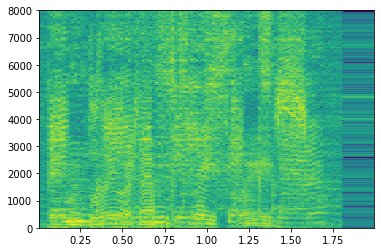

In [29]:
mean = np.loadtxt(os.path.normpath(os.path.join(write_path,'mean_mixed_log.txt')))
std = np.loadtxt(os.path.normpath(os.path.join(write_path,'std_mixed_log.txt')))
hidden1_b_unnorm = (hidden1_b*std)+mean
recon = reconstruct(hidden1_b_unnorm/3, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

In [144]:
sd.play(recon,16000)

In [35]:
recon = reconstruct(hidden1_b, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\matplotlib\axes\_axes.py:7725: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


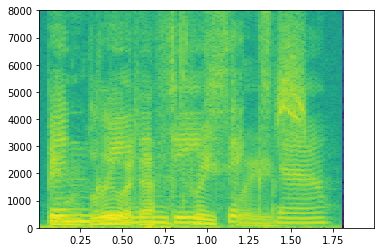

In [74]:
recon = reconstruct(ftr_raw, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)
from scipy import signal
# frequencies, times, spectrogram = signal.spectrogram(recon, 16000)
# plt.pcolormesh(times, frequencies, spectrogram)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.pcolormesh
# plt.show()
Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

In [76]:
ftr_phase.shape

(126, 257)

In [27]:
a=tf.constant([1,2,3])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    label_numpy = a.eval()

In [97]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0]
len_data=d.shape
hh.close()
len_data

(771,)

In [53]:
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=256, win_length=512, window='hann')
    return recon

In [92]:
dataset

<PrefetchDataset shapes: ((?, 257), (?,)), types: (tf.float32, tf.float32)>

In [56]:
h5f.close()

In [128]:
np.random.random_sample(10)

array([0.07630829, 0.77991879, 0.43840923, 0.72346518, 0.97798951,
       0.53849587, 0.50112046, 0.07205113, 0.26843898, 0.4998825 ])